<a href="https://colab.research.google.com/github/gabriel-cm-saldanha/Health-Insurance-Cost-Prediction/blob/main/Health_Insurance_Cost_Prediction_Regress%C3%A3o_com_PyCaret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão de custo do Seguro de Vida

Neste Projeto, iremos criar um modelo para prever o custo do seguro de vida de uma determinada seguradora. O mercado de seguros no Brasil movimenta mais de 98,91 bilhões de reais, segundo a SUSEP - [Superintendência de Seguros Privados](https://www.gov.br/susep/pt-br/arquivos/arquivos-dados-estatisticos/sinteses-mensais/2024/SinteseMensalJun2024final1.pdf)

Quando falamos de seguro de vida, a participação de mercado de 16.5%, equivalente a 16,38 bilhões de reais e apenas 17% da população adulta possui seguro de vida, sendo que 58% desse valor é referente a modalidade coletiva, que é quando a empresa fornece para seus colaboradores.

 "Esse tipo de serviço representa menos de 1% de participação no PIB [Produto Interno Bruto] brasileiro, muito distante da realidade de países como Reino Unido (8%) e Estados Unidos (cerca de 5%)"

<img width=50% src='https://seguronovadigital.com.br/wp-content/uploads/2023/02/seguro-de-vida-por-invalidez.jpg'></img>

Para criarmos um modelo de previsão do custo, é importante entendermos como ele é realizado. O cálculo do custo do seguro de vida envolve diversas variáveis como as tábuas de mortalidade, que fornecem uma base, mas também são consideradas fatores como:
* Histórico médico pessoal e familiar;
* IMC
* Histórico de condução (multas, processos etc)


Fonte:

[Bradesco Seguros](https://estudio.folha.uol.com.br/bradesco-vida-e-previdencia/2024/05/cresce-adesao-de-brasileiros-a-seguros-de-vida.shtml#:~:text=Isso%20porque%20s%C3%B3%2017%25%20da,por%20empresas%20aos%20seus%20colaboradores.)

[Seguro de vida - Wikipedia](https://en.wikipedia.org/wiki/Life_insurance)

## Sobre os Dados
### Obtenção
Os dados utilizados foram disponibilizados no [Kaggle](https://www.kaggle.com/datasets/annetxu/health-insurance-cost-prediction/data).

Também é possivel importa-lo diramente da biblioteca do PyCaret ou no repositório do [GitHub](https://github.com/pycaret/pycaret/tree/master/datasets)

Esse dataset contém 1338 linhas, com 7 colunas, sendo uma dessas colunas a variável alvo.

### Dicionários de Variáveis

* Age - Idade do cliente
* Sex - Gênero do cliente
* BMI - Índice de Massa Corporal (IMC)
* Children - Quantidade de filhos
* Smoker - Se é fumante ou não
* Region - A região onde o cliente mora
* Charges - Valor pago anualmente no seguro de vida

## Configurando o Notebook

### Instalando Pacotes Necessários

Neste projeto iremos trabalhar com PyCaret, e para isso precisamos instalar alguns pacotes pois o PyCaret não consta no conjunto de pacotes previamente instalados no Google Colab.
Por conta de algumas funções, precisamos instalar uma versão específica do *Scipy* para não termos erros durante a execução do código.

In [ ]:
# instalando as bibliotecas necessárias
!pip install scipy==1.9.3
!pip install pycaret -q
!pip install mlflow -q
!pip install shap -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importando os pacotes de Machine Learning
from pycaret.regression import (setup,
                                compare_models,
                                models,
                                create_model,
                                predict_model)
from pycaret.regression import (tune_model,
                                plot_model,
                                interpret_model,
                                evaluate_model,
                                finalize_model)
from pycaret.regression import (save_model,
                                load_model)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

## Análise Exploratória

Vamos começar importando o conjunto de dados, e imprimir as 5 primeiras linhas para visualizarmos como estão dispostos os dados que iremos trabalhar.

Possuimos três variáveis categóricas e quatro variáveis numéricas, o que nos indica que teremos que trabalhar com algum tipo de *Encoder* para as variáveis categóricas.

Nosso conjunto de dados possui 1338 linhas, 7 colunas, e nenhum dado ausente. O tipo de dado de cada coluna está correto, não havendo necessidade de tratamento dos dados.

In [ ]:
# Importando os dados
DATA_PATH = 'https://raw.githubusercontent.com/gabriel-cm-saldanha/Health-Insurance-Cost-Prediction/main/insurance.csv'
df = pd.read_csv(DATA_PATH)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.shape

(1338, 7)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.isnull().sum().to_frame().T

,age,sex,bmi,children,smoker,region,charges
0,0,0,0,0,0,0,0


Utilizamos a função `describe` pois ela nos fornece insights estatísticos valiosos.

Podemos observar que:
* a idade média é de 39 anos
  * possuimos um desvio padrão alto para as idades, de 14 anos;
  
* Na média as pessoas possuem 1 filho, porém a casos em que possuem 5 filhos.

* O valor médio pago é de US 13.270,42
  * com um desvio padrão de US 12.110 - valor bem alto considerando a média
  * valor mínimo de US 1.121
  * valor máximo de US 63.770,42

In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Vamos começar fazendo uma análise por gênero para verificarmos se possui uma influência no custo do seguro.  

Começaremos plotando um gráfico da distribuição por gênero. Após plotar o gráfico, vemos que temos uma distribuição bem equilibrada entre o número de homens e mulheres no nosso conjunto de dados.

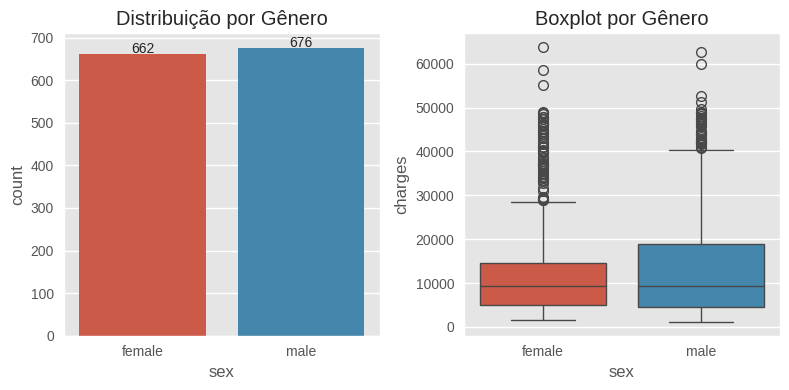

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

contagem = sns.countplot(x='sex', data=df, hue='sex', ax=ax[0])
contagem.set_title('Distribuição por Gênero')

for p in contagem.patches:
    contagem.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()+10),
                ha='center', va='center')

sns.boxplot(x='sex',y='charges', hue='sex', data=df, ax=ax[1])
ax[1].set_title('Boxplot por Gênero')

plt.tight_layout()
plt.show()

In [ ]:
df_male = df[df['sex'] == 'male']
df_female = df[df['sex'] == 'female']

In [ ]:
IQR_male = df_male['charges'].quantile(0.75) - df_male['charges'].quantile(0.25)
IQR_female = df_female['charges'].quantile(0.75) - df_female['charges'].quantile(0.25)

LSup_male = df_male['charges'].quantile(0.75) + 1.5 * IQR_male
LSup_female = df_female['charges'].quantile(0.75) + 1.5 * IQR_female

outliers_male = df_male[(df_male['charges'] > LSup_male)]
outliers_female = df_female[(df_female['charges'] > LSup_female)]

print(f'Outliers Male: {outliers_male.value_counts().sum()}')
print(f'Outliers Female: {outliers_female.value_counts().sum()}')

Outliers Male: 44
Outliers Female: 65


In [ ]:
outliers_female.groupby(['smoker'])[['charges', 'age']].agg(['min','max','mean']).round(2)

charges                    age           
             min       max     mean min max   mean
smoker                                            
no      28923.14  36910.61  33121.8  52  62  57.43
yes     28950.47  63770.43  41056.8  18  64  41.16

Como estamos buscando analisar se essa variável influencia o preço do seguro, vamos criar dois dataframes, um do sexo masculino e outro referente ao sexo femino e utilizar a função `describe` para verificar se existe alguma diferença aparente entre eles.

Alguns insights que podemos extrair:
* O gênero feminino apresenta o maior valor de `charges` de U$ 63.770,42
* Temos mais outliers no Genêro feminino que masculino
* Ambos apresentam uma alta variabilidade em `charges`
* Tanto `Age` como `bmi` apresentam valores bem próximos para ambos os sexos

In [ ]:
df_combined = pd.concat([df_male.describe(), df_female.describe()], axis=1, keys=['Male', 'Female'])
df_combined.swaplevel(axis=1).sort_index(axis=1)

age                     bmi                   charges  \
           Female        Male      Female        Male        Female   
count  662.000000  676.000000  662.000000  676.000000    662.000000   
mean    39.503021   38.917160   30.377749   30.943129  12569.578844   
std     14.054223   14.050141    6.046023    6.140435  11128.703801   
min     18.000000   18.000000   16.815000   15.960000   1607.510100   
25%     27.000000   26.000000   26.125000   26.410000   4885.158700   
50%     40.000000   39.000000   30.107500   30.687500   9412.962500   
75%     51.750000   51.000000   34.313750   34.992500  14454.691825   
max     64.000000   64.000000   48.070000   53.130000  63770.428010   

                       children              
               Male      Female        Male  
count    676.000000  662.000000  676.000000  
mean   13956.751178    1.074018    1.115385  
std    12971.025915    1.192115    1.218986  
min     1121.873900    0.000000    0.000000  
25%     4619.134000    0.000000    0.000000  
50%     9369.615750    1.000000    1.000000  
75%    18989.590250    2.000000    2.000000  
max    62592.873090    5.000000    5.000000

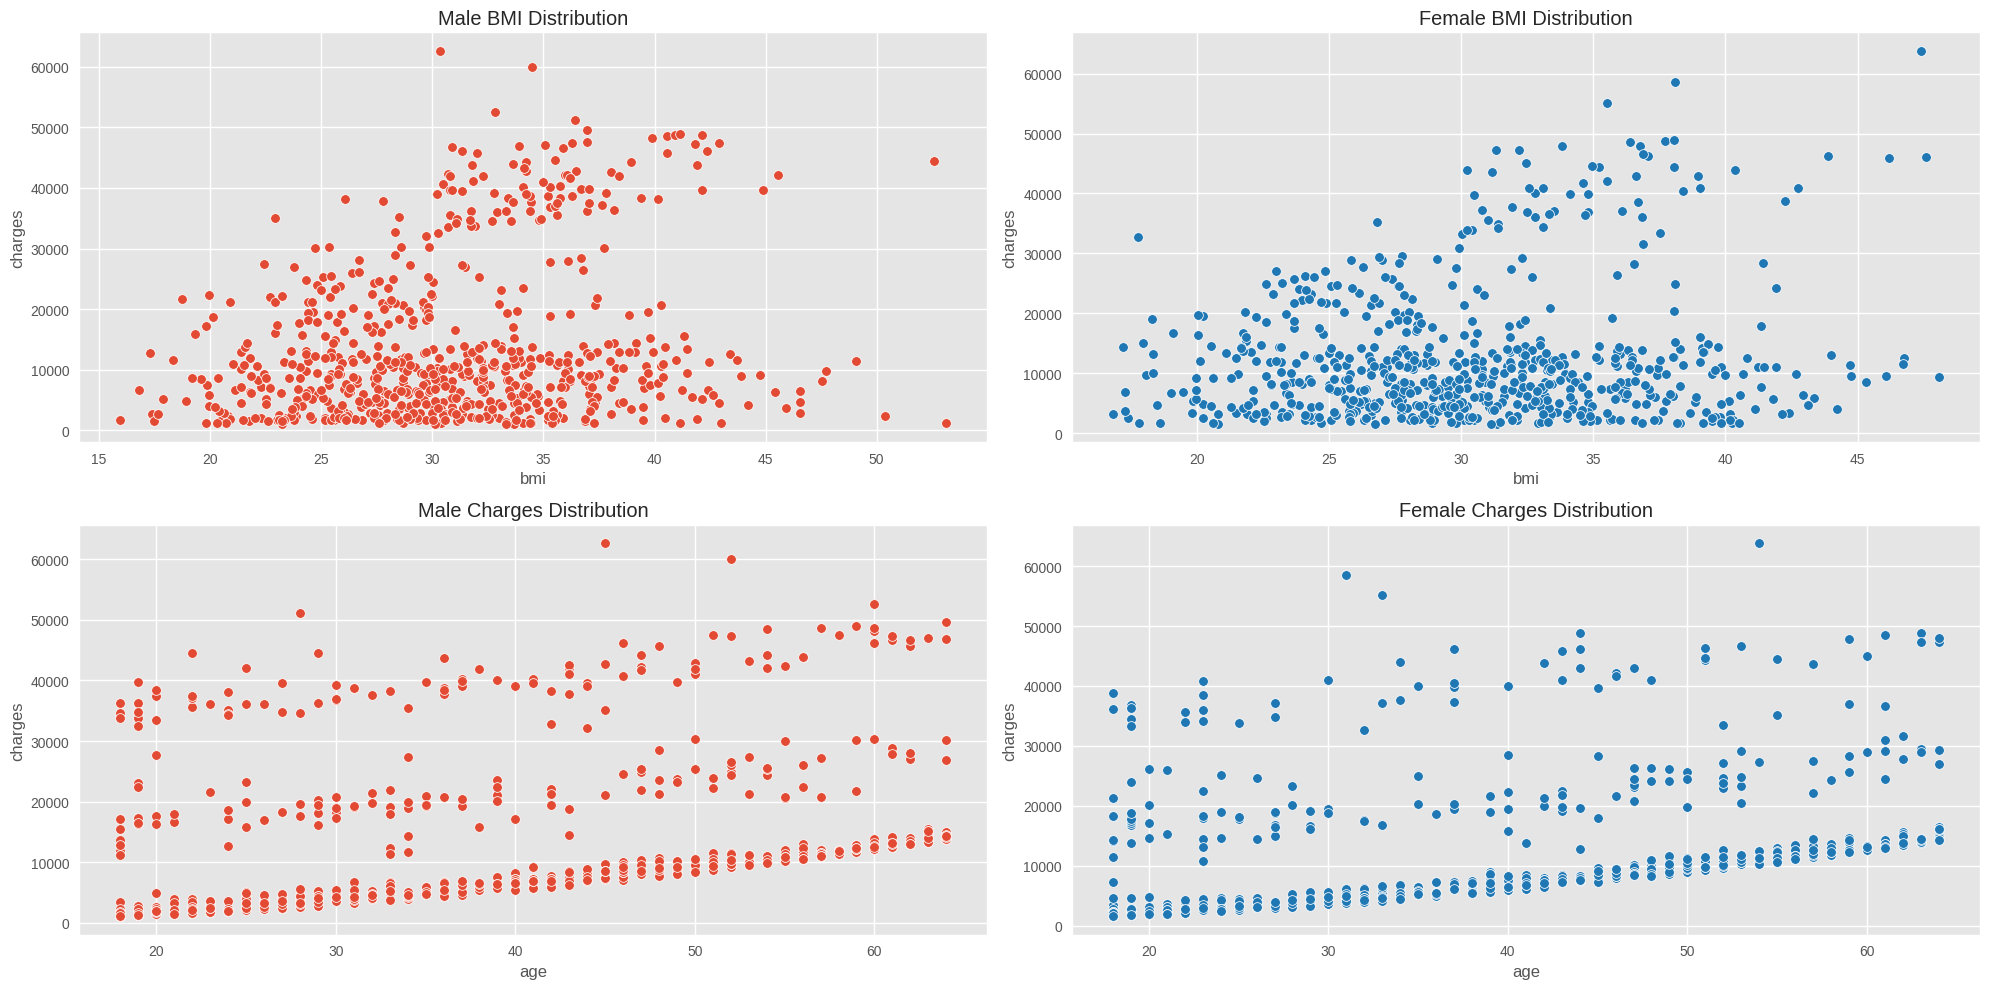

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,10))

sns.scatterplot(x='bmi', y='charges', data=df_male, ax=ax[0,0])
ax[0,0].set_title('Male BMI Distribution')

sns.scatterplot(x='bmi', y='charges', data=df_female, ax=ax[0,1], c='tab:blue')
ax[0,1].set_title('Female BMI Distribution')

sns.scatterplot(x='age', y='charges', data=df_male, ax=ax[1,0])
ax[1,0].set_title('Male Charges Distribution')

sns.scatterplot(x='age', y='charges', data=df_female, ax=ax[1,1], c='tab:blue')
ax[1,1].set_title('Female Charges Distribution')

plt.tight_layout()
plt.show()

Vamos filtrar um pouco mais nossa análise e adicionar a variável `smoker` como um filtro adicional, já que somente a variável `sex` não apresentou muita diferença entre os dois grupos.

Plotaremos um gráfico de dispersão novamente, mas dessa vez não criaremos gráficos distintos para cada variável, utilizaremos os próprios filtros do seaborn, com `hue = sex` para colorirmos de cores diferentes essa variável, e `style = smoker` que modifica o estilo dos pontos.

Também plotamos um gráfico BoxPlot para `smoker` dividindo entre `sex` para aprofundarmos um pouco mais na análise.

Observamos que `smoker` pode ter uma influência significativa no custo do seguro, mas não é via de regra, pois temos varios casos de pessoas que não fumam com valor de `charge` superior a quem é fumante. Um fato interessante é que homens fumantes apresentam um custo maior que mulheres fumantes porém os não fumantes é o contrário, mulheres com `charge` maior que homens.

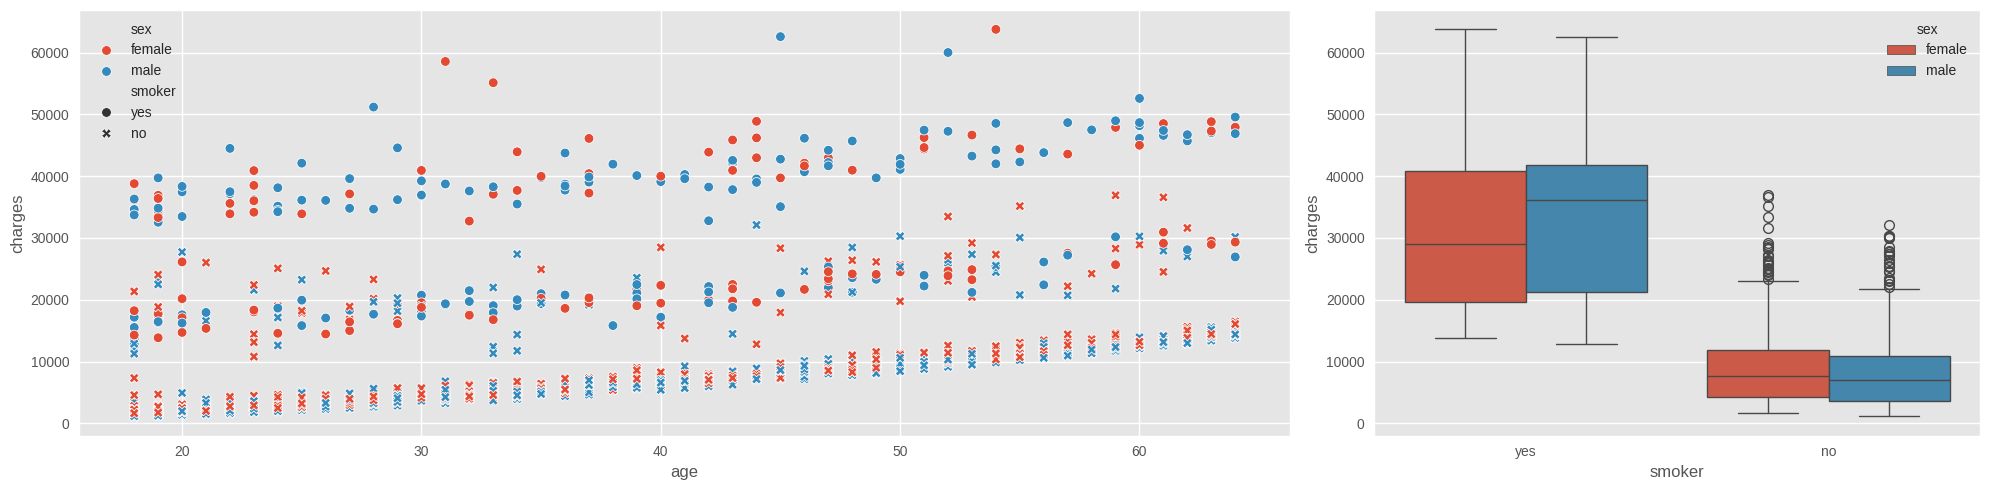

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5), width_ratios=[2,1])
sns.scatterplot(x='age', y='charges', data=df, hue='sex', style='smoker', ax=ax[0])
sns.boxplot(x='smoker',y='charges',hue='sex', data=df, ax=ax[1])

plt.tight_layout()
plt.show()

In [ ]:
df.groupby(['smoker','sex'])[['sex','charges']].agg({'sex':'count','charges':'mean'})

sex       charges
smoker sex                      
no     female  547   8762.297300
       male    517   8087.204731
yes    female  115  30678.996276
       male    159  33042.005975

Agora vamos analisar também as regiões. Começaremos verificando a quantidade de fumantes por região, pois vimos que `smoker == yes` normalmente possui valores de `charge` mais altos que `smoker == no`.

Alguns pontos interessantes:
* A região Southeast (sudeste) apresenta o maior número de fumantes
* A região Southwest (sudoeste) e northwest (noroeste) apresentam o mesmo número de fumantes e não fumantes
 * Apesar de apresentarem quantidades iguais, a distribuição dos valores de `charge` é diferente, com valores de mediana e máximo bem diferentes para os fumantes;
 * Southwest apresenta uma mediana próxima dos 36.000 equanto Northwest próxima de 28.000
 * Southwest apresenta valor máximo inferior a Northwest
* A mediana das regiões do Norte possuem valor inferior as regiões do Sul

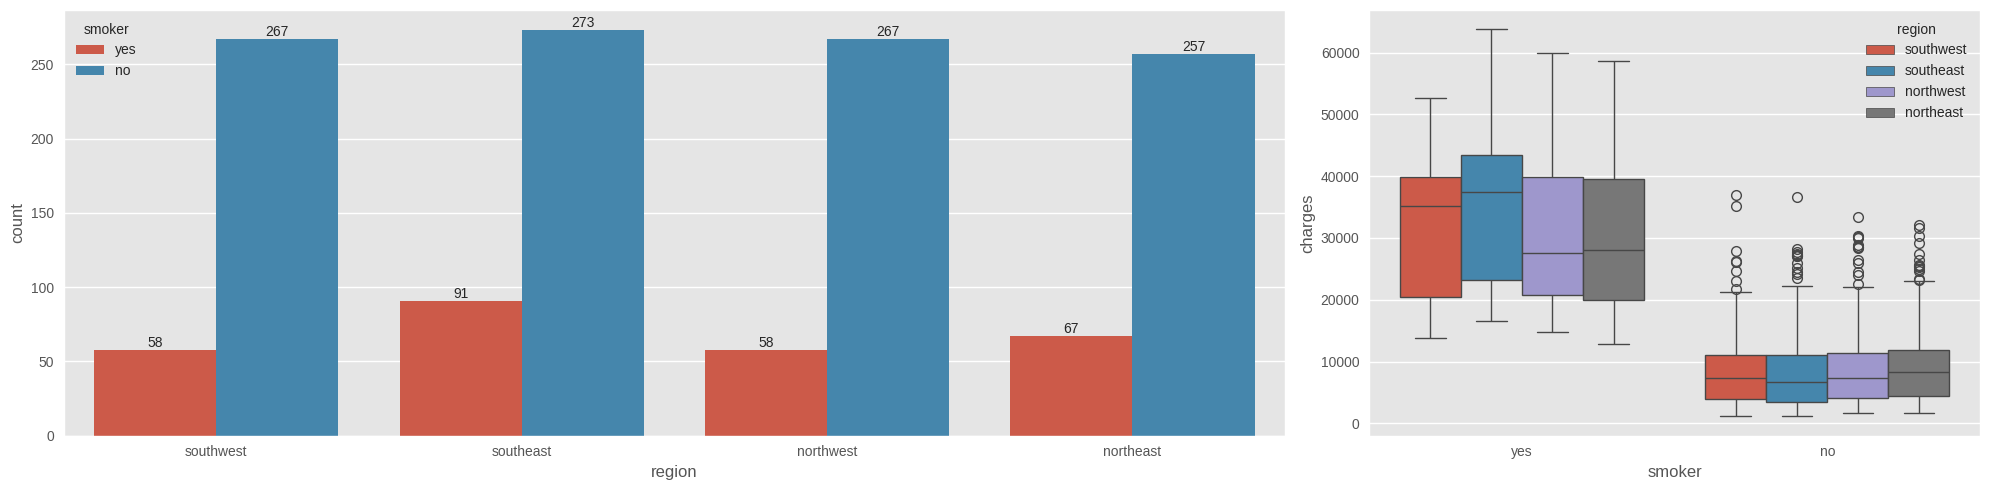

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5), width_ratios=[2,1])

graph_1 = sns.countplot(x='region', data=df, hue='smoker', ax=ax[0])
sns.boxplot(x='smoker',y='charges',hue='region', data=df, ax=ax[1])


for p in graph_1.patches:
    if p.get_height() > 0:  # Certifique-se de que a barra é visível
        graph_1.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

In [ ]:
df.groupby(['region','smoker','sex'])['charges'].mean()

region     smoker  sex   
northeast  no      female     9640.426984
                   male       8664.042222
           yes     female    28032.046398
                   male      30926.252583
northwest  no      female     8786.998679
                   male       8320.689321
           yes     female    29670.824946
                   male      30713.181419
southeast  no      female     8440.205552
                   male       7609.003587
           yes     female    33034.820716
                   male      36029.839367
southwest  no      female     8234.091260
                   male       7778.905534
           yes     female    31687.988430
                   male      32598.862854
Name: charges, dtype: float64

Por fim, vamos analisar a variável `children` (quantidade de filhos). Observamos que aparentemente não há uma relação entre as variáveis. O valor da mediana do custo do seguro para variável `children` são bem próximos, porém em alguns casos apresentam uma alta variabildiade nos preços, principalmente entre 0 e 2 filhos.

<Axes: xlabel='children', ylabel='charges'>

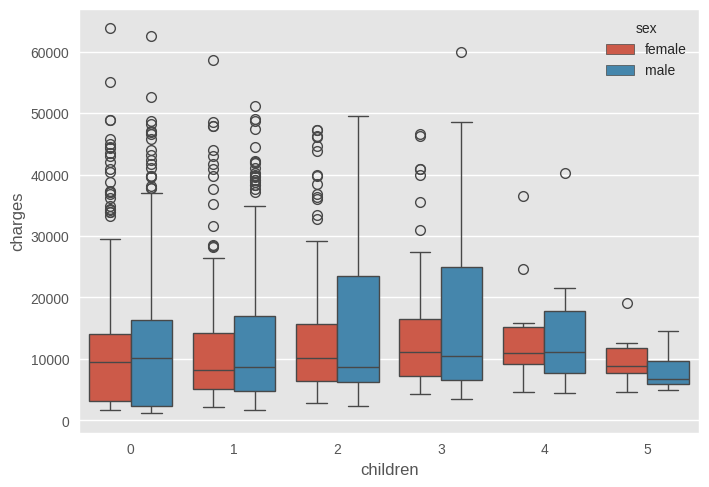

In [ ]:
sns.boxplot(x='children', y='charges',hue='sex', data=df)

In [ ]:
df.groupby(['children'])['charges'].agg(['mean','median','min','max','std'])

,mean,median,min,max,std
children,,,,,
0,12365.975602,9856.95190,1121.8739,63770.42801,12023.293942
1,12731.171832,8483.87015,1711.0268,58571.07448,11823.631451
2,15073.563734,9264.97915,2304.0022,49577.66240,12891.368347
3,15355.318367,10600.54830,3443.0640,60021.39897,12330.869484
4,13850.656311,11033.66170,4504.6624,40182.24600,9139.223321
5,8786.035247,8589.56505,4687.7970,19023.26000,3808.435525


## Machine Learning
Nesta etapa daremos inicio ao desenvolvimento do nosso modelo de previsão de custo do seguro de vida.

Para isso, utilizaremos o PyCaret que é uma solução Low Code que visa criar modelos de machine learning.


Começamos separando os dados entre dados de treino e de teste.

In [ ]:
test = df.sample(frac=0.20)
train = df.drop(test.index)

test.reset_index(inplace=True, drop=True)
train.reset_index(inplace=True, drop=True)

### Criando Pipeline

O PyCaret já conta com a criação e estruturação do pipeline, porém podemos alterar os parâmetros que vem como padrão.

No nosso pipeline, iremos normalizar os dados.
Quanto a divisão dos dados, utilizaremos 80% para treino e 20% para validação, e será utilizada validação cruzada.

In [ ]:
reg = setup(data = train,
            target = 'charges',
            log_experiment = True,
            normalize = True,
            fold_shuffle = True,
            train_size=0.8,
            experiment_name = 'sales_01')

,Description,Value
0,Session id,8366
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1070, 7)"
4,Transformed data shape,"(1070, 10)"
5,Transformed train set shape,"(856, 10)"
6,Transformed test set shape,"(214, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


### Comparando Modelos

O modelo que melhor perfomou no nosso conjunto de modeos foi o *Gradient Boosting Regressor* apresentando as seguintes métricas:
* MAE : 2187.5932
* MSE : 17839678.1663
* RMSE : 4111.9430
* R2 : 0.8714
* RMSLE : 0.4217

Apesar de ele ter sido o que melhor performou, iremos otimizar outros modelos afim de buscar resultados ainda melhores.
Iremos utilizar o Random Forest Regressor e o LightGBM.

In [ ]:
best = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2420.5328,20724838.7964,4479.9576,0.8601,0.4285,0.2894,0.1960
rf,Random Forest Regressor,2548.5072,22575563.9622,4695.3363,0.8464,0.4735,0.3181,0.6300
lightgbm,Light Gradient Boosting Machine,2739.3986,23142156.9927,4725.7733,0.8435,0.5204,0.3434,0.9250
et,Extra Trees Regressor,2630.9630,26248540.8419,5074.2460,0.8228,0.5081,0.3414,0.3470
ada,AdaBoost Regressor,3994.1189,26920162.2493,5154.7472,0.8179,0.6158,0.6900,0.1200
xgboost,Extreme Gradient Boosting,2887.9286,27564312.7000,5177.8870,0.8106,0.5355,0.3734,0.2770
knn,K Neighbors Regressor,3370.8193,31240865.8000,5506.6349,0.7879,0.4998,0.3632,0.1140
br,Bayesian Ridge,4302.7355,36297093.7965,5995.7301,0.7530,0.6567,0.4495,0.1070
lar,Least Angle Regression,4300.3584,36296422.6883,5995.6690,0.7529,0.6231,0.4490,0.3570
llar,Lasso Least Angle Regression,4300.0509,36294612.7990,5995.5211,0.7529,0.6239,0.4490,0.1060


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

2024/08/29 19:23:19 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/29 19:23:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


2024/08/29 19:23:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/29 19:23:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/29 19:23:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/29 19:23:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/29 19:23:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/29 19:23:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

In [ ]:
print(best)

[GradientBoostingRegressor(random_state=8366), RandomForestRegressor(n_jobs=-1, random_state=8366), LGBMRegressor(n_jobs=-1, random_state=8366)]


### Gradient Boost Regressor

Vamos instanciar o modelo GBR que vimos anteriormente, utilizando o `random_state = 4627`

In [ ]:
gbr = create_model('gbr', random_state=7193)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2246.2516,17934930.0671,4234.9652,0.8760,0.3603,0.2333
1,3148.7203,35345185.6411,5945.1817,0.7671,0.4913,0.2449
2,3127.4454,33070850.6854,5750.7261,0.8197,0.5140,0.3085
3,2312.3275,22763910.7661,4771.1540,0.8454,0.3846,0.2526
4,2196.9686,14241682.5056,3773.8154,0.8662,0.4633,0.3560
5,2545.1369,24502504.3151,4950.0004,0.8159,0.4769,0.2433
6,2111.9232,18286209.7038,4276.2378,0.8945,0.4305,0.3358
7,2265.3385,15391153.9405,3923.1561,0.8948,0.4020,0.2850
8,2069.5384,12448897.8295,3528.2996,0.9331,0.3696,0.3098


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

2024/08/29 19:23:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


#### Tuning do Modelo

Iremos utilizar a função `tune_model` para otimizar os hiperparâmetros do modelo.

Infelizmente não conseguimos melhorar o resultado do nosso modelo. Tentamos a otimização por outras métricas como *MAE, MSE, RMSE*, mas também não entregaram melhoria nos resultados, então seguiremos utilizando o modelo sem otimização.

Parâmetros antes da otimização:
* MAE: 2488.2593
* MSE: 20965246.6068
* RMSE:	4548.0128
* R2:	0.8543
* RMSLE:	0.3980

Parâmetros obtidos na otimização:
* MAE: 3061.4070
* MSE: 23739439.5770
* RMSE:	4850.7255
* R2:	0.8304
* RMSLE:	0.5702

In [ ]:
tuned_gbr = tune_model(gbr, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2596.7077,17910552.7728,4232.0861,0.8762,0.4034,0.3146
1,3361.1288,34169584.0927,5845.4755,0.7748,0.5081,0.3356
2,3333.8444,32881148.0896,5734.2086,0.8207,0.5004,0.3656
3,2682.1045,23521189.6655,4849.8649,0.8402,0.4578,0.3752
4,2537.5183,14698243.3439,3833.8288,0.8619,0.4966,0.4508
5,2812.9440,22944651.4246,4790.0576,0.8276,0.4772,0.3342
6,2653.5916,19304641.4310,4393.7048,0.8886,0.5029,0.4785
7,2584.2820,16156532.6174,4019.5190,0.8896,0.4322,0.3646
8,2386.8371,12592949.9533,3548.6547,0.9323,0.4704,0.4555


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2024/08/29 19:24:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


### Random Forest Regressor

In [ ]:
rf = create_model('rf', random_state=5457)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2428.0143,20143789.1066,4488.1833,0.8608,0.4351,0.3044
1,3093.0730,36081849.0706,6006.8169,0.7622,0.5360,0.2292
2,3149.8446,34109133.1528,5840.3025,0.8140,0.5370,0.2966
3,2682.8529,27360888.9933,5230.7637,0.8141,0.4793,0.3582
4,2433.1201,18270193.8982,4274.3647,0.8284,0.4998,0.3487
5,2679.2441,26282541.1803,5126.6501,0.8025,0.5067,0.2403
6,2362.3101,18964251.2640,4354.7964,0.8906,0.4899,0.4095
7,2393.3636,16633260.7825,4078.3895,0.8863,0.4444,0.3410
8,2015.7890,12622183.2452,3552.7712,0.9322,0.3969,0.3170


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

2024/08/29 19:24:30 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [ ]:
tuned_rf = tune_model(rf, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2166.6362,18763832.9041,4331.7240,0.8473,0.4418,0.2173
1,2657.9560,30582597.6515,5530.1535,0.7720,0.4450,0.1846
2,1890.9658,15960759.7754,3995.0920,0.8988,0.3534,0.1597
3,2023.9381,17715237.5795,4208.9473,0.8648,0.3208,0.1584
4,1742.0626,15290836.6994,3910.3499,0.8970,0.2760,0.1705
5,2633.0778,30423179.1061,5515.7211,0.8497,0.4183,0.1910
6,1662.3285,16414397.6868,4051.4686,0.8879,0.3012,0.1509
7,2888.9006,38488071.7907,6203.8755,0.6725,0.4558,0.1809
8,1756.3768,17078806.4298,4132.6513,0.8619,0.2741,0.1312


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


2024/08/29 19:21:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


### Light Gradient Boosting Machine

In [ ]:
lgbm = create_model('lightgbm', random_state=5457)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2471.1541,19095376.1881,4369.8256,0.8680,0.4625,0.2735
1,3557.6244,39865313.6293,6313.8984,0.7373,0.6130,0.3041
2,3644.9330,37439542.4212,6118.7860,0.7959,0.6323,0.3642
3,2901.4111,28141585.0576,5304.8643,0.8088,0.5222,0.3588
4,2529.6631,16730909.9906,4090.3435,0.8428,0.5563,0.3907
5,2888.3386,26220973.6209,5120.6419,0.8030,0.6308,0.3151
6,2383.6203,19584398.6862,4425.4264,0.8870,0.4925,0.3875
7,2502.1295,16700980.3398,4086.6833,0.8859,0.4271,0.3321
8,2137.5684,12530873.1834,3539.8973,0.9327,0.4003,0.3267


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

2024/08/29 19:24:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [ ]:
tuned_lgbm = tune_model(lgbm, optimize='RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2200.5390,17493266.5521,4182.4953,0.8791,0.3531,0.2175
1,3272.6583,35501373.5071,5958.3029,0.7661,0.5198,0.2808
2,3528.6046,36928202.0585,6076.8579,0.7987,0.5506,0.3273
3,2765.1499,23762426.7298,4874.6720,0.8386,0.4045,0.2947
4,2285.4411,13742729.7002,3707.1188,0.8709,0.4755,0.3489
5,2909.1488,26732173.0202,5170.3165,0.7991,0.5052,0.2768
6,2276.4995,18160611.2215,4261.5269,0.8952,0.4559,0.3885
7,2363.8380,15092139.1084,3884.8602,0.8969,0.4312,0.2807
8,2157.4704,12165573.5815,3487.9182,0.9346,0.4098,0.3332


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


2024/08/29 19:25:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


### Plotando Modelo

Seguiremos com o modelo do Gradient Boost Regressor, pois foi o que melhor performou antes e depois da otimização dos hiperparâmetros.

No gráfico abaixo podemos observar a linha *identity* que seria o modelo ideal onde as previsões seriam o mais próximas do valor real, e a reta *best fit* que representa nosso modelo.

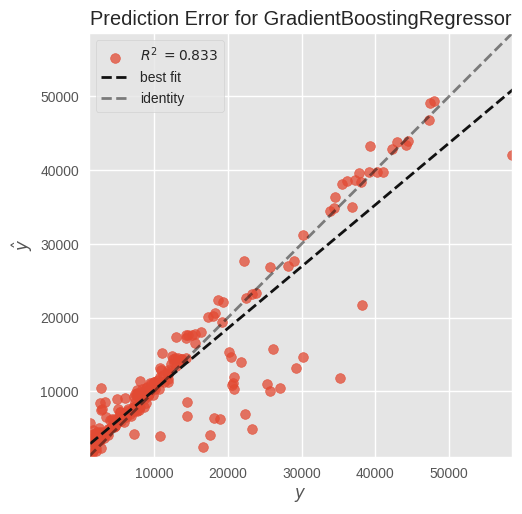

In [ ]:
plot_model(gbr, plot='error')

Ao plotar o gráfico de *Feature Importance*, confirmamos uma tese que já haviamos explorado anteriormente sobre o impacto/importância da variável `smoker` para o nosso modelo. Apesar do custo estar melhor distribuido em 3 faixas quando comparado com a variável `age`, `bmi` mostra-se mais relevante para o modelo.

Como suspeitávamos, `children` é uma variável de pouca importância para o nosso modelo, pois aparentemente não está relacionado ao número de dependentes, apenas a quantidade, não impactando no preço.


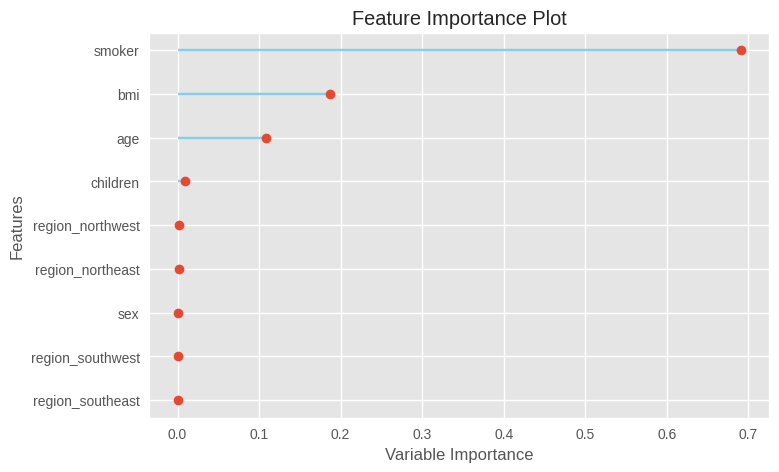

In [ ]:
plot_model(gbr, plot='feature')

### Avaliação Interativa do Modelo - GBR

Utilizamos a função `evalute_model` do PyCaret para adicionar uma avaliação interativa do nosso modelo. Essa função "empacota" todas as funções de visualização, simplificando a visualização de diversas métricas com uma linha de código.

In [ ]:
evaluate_model(gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Fazendo Previsões

Agora iremos validar nosso modelo. Antes de instanciarmos nosso modelo, separamos os dados em teste e treino, porém não serão esses os dados utilizados nesta etapa. Para instanciarmos o modelo, definimos alguns parâmetros dentro da função `setup` como `train_size = 0.8` e `data=train`, ou seja, dos dados que separamos entre `train` e `test`, o modelo separa 80% dos dados do conjunto `train` como treino e 20% como validação.

In [ ]:
predict_model(gbr).head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2708.0872,23308892.8971,4827.9284,0.8327,0.4614,0.3400


,age,sex,bmi,children,smoker,region,charges,prediction_label
838,28,female,25.799999,0,no,southwest,3161.454102,3726.165250
446,41,male,30.590000,2,no,northwest,7256.723145,7894.834923
981,20,female,24.420000,0,yes,southeast,26125.673828,15804.023654
671,28,female,23.844999,2,no,northwest,4719.736328,5366.276849
492,49,male,25.600000,2,yes,southwest,23306.546875,23188.555456


### Finalizando o Modelo
Realizado a validação do modelo, iremos finalizar o modelo, para isso utilizaremos a função `finalize_model`, ela treina o modelo novamente utilizando os dados de treino e validação.

In [ ]:
final_gbr = finalize_model(gbr)

2024/08/29 19:26:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


### Previsão em Dados Novos
Finalizado o modelo, iremos testar o modelo nos nossos dados de teste que separamos anteriormente.

Importante lembrar que nosso modelo foi treinado também com os dados de validação.

In [ ]:
predict_model(final_gbr, data=test).head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2643.8609,23104414.9534,4806.7052,0.8358,0.4247,0.3194


,age,sex,bmi,children,smoker,region,charges,prediction_label
0,39,male,26.219999,1,no,northwest,6123.568848,6890.657043
1,46,male,24.795000,3,no,northeast,9500.573242,10684.671987
2,22,male,37.070000,2,yes,southeast,37484.449219,37732.824628
3,46,male,26.620001,1,no,southeast,7742.109863,8692.319186
4,21,male,28.975000,0,no,northwest,1906.358276,2407.877714


### Salvando e Carregando o Modelo
Pronto o modelo, vamos salva-lo para que possa ser utilizado para fazer previsões em novos dados.

In [ ]:
save_model(final_gbr,'Modelo_Final_GBR')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['age', 'bmi', 'children'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['sex', 'smoker', 'region'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['sex', 'smoker'],
                                     transfor...
                                                                         {'col': 'smoker',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': no     0
 yes    1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['region'],
    

A função `load_model` permite carregarmos nosso modelo, passando como parâmetro o nome do arquivo do modelo. Após carregar o modelo, o mesmo se encontra pronto para previsão de novos dados por meio da função `predict_model`, informando o novo conjunto de dados no parâmetro `data`.

In [ ]:
model = load_model('Modelo_Final_GBR')

Transformation Pipeline and Model Successfully Loaded
